In [1]:
import numpy as np
from collections import namedtuple
from matplotlib import pyplot as plt 
from ipywidgets import interact, FloatSlider, IntSlider, fixed
from filterpy.kalman import predict, update
from filterpy.stats import plot_covariance
from scipy.linalg import inv
%run utils.py

# Kalman Filter

## Introdução
### Assimilação de Dados
A idéia principal de assimilação de dados é combinar conhecimento teórico sobre um sistema em conjunto com dados observados.
Um modelo matemático é uma das formas de representar o conhecimento teórico sobre o sistema. Em particular, modelos de sistemas dinâmicos são muito utilizados para realizar estimativas e projeções sobre um sistema. Entretanto, de forma geral, modelos matemáticos são aproximações da realidade, e por isso não representam perfeitamente toda a complexidade do sistema modelado.
Por outro lado, dados coletados do ambiente real, seja manualmente ou por meio de sensores, podem aprensentar erros por conta de ruído. Por isso, dependendo da aplicação, podem não ser adequados.
A correção dos modelos e de técnicas de coleta de dados para diminuição do erro é muitas vezes inviável, seja pela complexidade do sistema ou pelo alto custo e impraticidade de obtenção de dados.
Algoritmos de assimilação de dados utilizam modelos matemáticos em conjunto com dados observados, obtendo uma estimativa com acurácia superior a ambos.

- **Exemplo GPS**
Tomando como exemplo o GPS de um carro. Se a acurácia do GPS for baixa, teremos uma estimativa de uma região onde o carro pode estar localizado. Entretanto, sabemos a região aproximada de onde o carro estava há 1 segundo atrás. Também sabemos o comportamento da posição do carro. Podemos representar este comportamento como um modelo matemático ($\Delta S = S + v \cdot t$). Se soubermos a velocidade, por meio do modelo podemos projetar a posição aproximada do carro. Portanto, temos duas fontes de informação para estimar a posição atual do carro. A posição projetada pelo modelo em função da posição anterior e da velocidade, e a posição informada pelo GPS. O trabalho do filtro é unir essas informações para melhorar a estimativa atual do carro.

- **Distinto de machine learning**
Vale apena observar que técnicas de assimilação são distintas de técnicas aprendizado de máquinas. Na assimilação de dados, possuímos a priori um modelo que representa o comportamento do sistema. Em aprendizado de máquinas, o modelo é criado exclusivamente em cima dos dados observados. Por isso, assimilação de dados requer uma quantidade muito menor de dados para obter bons resultados.

<img src="./fig/data_assimilation.png">

## Revisão de Estatística e Variáveis Normais


 **Objetivo: Função Gaussiana**

É comum utilizar funções gaussianas para representar incertezas no mundo real. Uma função de densidade de probabilidade gaussiana nos dá a previsão que uma estimativa (média) tem muito mais chande de estar certa do que de estar errada, mas ainda assim, a probabilidade de estar errada não é nula.


Nosso objetivo utilizando o Kalman Filter é justamente descrever eventos como funções gaussianas. Ou seja, dado que haja uma previsão do que vai acontecer, também existe uma incerteza associada. Isso porque medições e modelos tem um viés.

<img src="./fig/gausscurve.png" style="width: 400px;">

**Função de Distribuição Gaussiana**

A função Gaussiana é uma função de distribuição de probabilidade contínua que pode ser descrita através de dois parâmetros, uma média ($\mu$) e uma variância ($\sigma^2$). A função densidade de probabilidade dela é definida como:
$$ 
f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\big [{-\frac{(x-\mu)^2}{2\sigma^2} }\big ]
$$

Usando funções gaussianas, existe a possibilidade de expressar distribuições de probabilidade para todos os valores através de apenas dois parâmetros. Quem são esses valores?

- Média

A média associada a uma função probabilidade é uma tendência de resultados de um evento evento a permanecerem ao redor de um evento médio. "Em média" os resultados de um evento estão próximos da média. Podemos considerar a média como uma previsão de um evento.

- Variância

A variância associada a uma função de probabildade é o quanto os resultados de um evento se distanciam da média. Quanto maior a variância, menos conhecemos do evento que estudamos e menos precisa é a previsão feita. Quanto menor a variância, mais conhecemos do evento que está sendo estudado e mais precisa é a previsão feita.

Então, queremos associar uma variável aleatória (um evento ou fenômeno que não temos conhecimento sobre) a dois parâmetros. Podemos fazer isso utilizando a notação ${\displaystyle X\sim {N}(\mu ,\sigma ^{2}).}$ 

Na função Gaussiana, a probabilidade do evento obter um resultado próximo da média é muito maior do que um resultado longe da média (previsão). Por isso ela retrata tão bem fenômenos naturais.

<img src="./fig/probgaussiana.png" style="width: 500px;">


In [2]:
interact(
    plot_gaussian,
    x_mean = FloatSlider(value = 0, min = -8, max = 8),
    x_var = FloatSlider(value = 0.6, min = 0, max = 5),
);

interactive(children=(FloatSlider(value=0.0, description='x_mean', max=8.0, min=-8.0), FloatSlider(value=0.6, …

**Operações associadas a Gaussianas:**

Para o Filtro de Kalman, vamos utilizar conceitos de operações entre funções Gaussianas de variáveis aleatórias **independentes**.

- Soma 

Dado dois eventos independentes $\displaystyle X$ e $\displaystyle Y$, vamos considerá-los descritos por uma função de distribuição normal, associando cada um deles a uma média e uma variância: ${\displaystyle X\sim {N}(\mu
_1 ,\sigma_1 ^{2})}$ e ${\displaystyle Y\sim {N}(\mu_2 ,\sigma_2 ^{2})}$. 

Se precisarmos realizar a soma do valor dessas variáveis, iremos obter um resultado que também carrega incertezas. A soma de duas gaussianas resulta em uma gaussiana com parâmetros:

$$\begin{gathered}\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

Essa operação pode ser provada através de convolução.


In [3]:
interact(
    plot_gaussian_sum,
    x_mean = FloatSlider(value = 0, min = 0, max = 5),
    x_var = FloatSlider(value = 0.6, min = .1, max = 3),
    dx_mean = FloatSlider(value = .4, min = -1, max = 1),
    dx_var = FloatSlider(value = 0.3, min = .1, max = 3)
);

interactive(children=(FloatSlider(value=0.0, description='x_mean', max=5.0), FloatSlider(value=0.6, descriptio…

- Multiplicação

Novamente, dado dois eventos independentes $\displaystyle X$ e $\displaystyle Y$, vamos considerá-los descritos por uma função de distribuição normal, associando cada um deles a uma média e uma variância: ${\displaystyle X\sim {N}(\mu_1 ,\sigma_1 ^{2})}$ e ${\displaystyle Y\sim {N}(\mu_2 ,\sigma_2 ^{2})}$. 

Se precisarmos multiplicar essas duas variáveis, esse resultado também carregará incertezas. A multiplicação de duas gaussianas resulta em uma gaussiana com parâmetros:
 
$$\begin{aligned}\mu &amp;=\frac{\sigma_1^2\mu_2 + \sigma_2^2\mu_1}{\sigma_1^2+\sigma_2^2}\\
\sigma^2 &amp;=\frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} 
\end{aligned}$$

A gaussiana resultante da multiplicação de duas gaussianas independentes sempre terá variância menor do que as variâncias das gaussianas originais. Então, com essa operação você está diminuindo sua incerteza em relação a um novo evento. Para Análise de dados: quanto mais informações você tem sobre um determinado processo, menos incerteza de seu resultado. O Kalman Filter usa essa propriedade matemática de minimização de variância para garantir seus resultados.

Essa operação provém da fórmula de Bayes.

In [4]:
interact(
    plot_gaussian_multiply,
    x_mean = FloatSlider(value = -2.5, min = -3, max = 3),
    x_var = FloatSlider(value = 0.6, min = 0, max = 3),
    z_mean = FloatSlider(value = 2.5, min = 0, max = 3),
    z_var = FloatSlider(value = 1.1, min = 0, max = 3)
);

NameError: name 'plot_gaussian_multiply' is not defined

## Kalman Filter


<img src="./fig/esquema_kf_1.jpg" style="width: 30cm">

Ideia Geral:
- Usar uma Gaussiana para representar nossa estimativa para o estado e erro associado a ela.
- Usar uma Gaussiana para representar as medidas e os erros associados a ela (Ex. Erro de Sensores).
- Usar uma Gaussiana para representar o modelo e o erro associado a ele (Ex. Efeitos físicos que não são contemplados pelo modelo).
- Usar o modelo para fazer uma previsão para o próximo estado (Chamamos essa previsão de PRIOR).
- Obter uma estimativa final para o estado como um valor entre a medida e o PRIOR (Chamamos essa estimativa final de POSTERIOR).


## Kalman Filter Unidimensional

<img src="./fig/gh_estimate3.png" style="width: 15cm">

#### Prediction
Na predição, utilizamos o modelo matemático para prever o estado do proximo passo de tempo. O resultado da predição é chamado de ***Prior***.

Para isso, somamos a gaussiana do estado do sistema com a gaussiana da variação do estado calculada pelo modelo.

**Cálculo da média do *prior***
$$\mu = \mu_1 + \mu_2 \quad \to \quad \bar x = x + dx$$

**Cálculo da variância do *prior***
$$\sigma^2 = \sigma^2_1 + \sigma^2_2 \quad \to \quad \bar \sigma_x^2 = \sigma_x^2 + \sigma_{dx}^2$$

Onde:

- $x$ é a média do *posterior* no passo de tempo anterior;
- $\sigma_x^2$ é a variância do *posterior* no passo de tempo anterior;
- $dx$ é o resultado do cálculo da derivada realizado pelo modelo;
- $\sigma_{dx}^2$ é a variância do modelo (e.g. a incerteza da predição).

#### Update
No update, utilizamos a medida no novo passo de tempo para diminuir a incerteza da predição (*prior*). O resultado do update é chamado de ***Posterior***

**Cálculo da média do *posterior***

Podemos derivar a fórmula da média de uma 'multiplicação' de duas gaussianas independentes:
$$\mu=\frac{\bar\sigma_x^2\, \mu_z + \sigma_z^2 \, \bar x} {\bar\sigma_x^2 + \sigma_z^2}$$

$$\mu = \left( \frac{\bar\sigma_x^2}{\bar\sigma_x^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma_x^2 + \sigma_z^2}\right)\bar x$$

$$\mu = W_1 \mu_z + W_2 \bar x \quad \to \quad W_2 = (1 - W_1)$$

$$\begin{aligned}
\mu &= K \mu_z + (1-K) \bar x\\
&= \bar x + K(\mu_z - \bar x)
\end{aligned}$$

Onde:
- $\bar x$ é a média do *prior*
- $\bar \sigma_x^2$ é a variância do *prior*
- $\mu_z$ é o valor da medição
- $\sigma_z^2$ é a variância do sensor
- K é uma proporção chamada de ***Kalman gain***

**Cálculo da variância do *posterior***

Também podemos expressar a variância em termos do *Kalman gain*

$$\begin{aligned}
\sigma^2 &= \frac{\bar\sigma^2 \sigma_z^2 } {\bar\sigma^2 + \sigma_z^2} \\
&= K\sigma_z^2 \\
&= (1-K)\bar\sigma^2 
\end{aligned}$$

**Resumindo**

Assim, o update pode ser escrito como:

$$y = \mu_z - \bar x$$
$$K = \frac {\bar\sigma_x^2}{\bar\sigma_x^2 + \sigma_z^2}$$
$$\mu = \bar x + K y$$
$$\sigma^2 = (1-K)\bar\sigma^2$$


<img src="./fig/residual_chart.png" style="width: 15cm">

## Implementação Kalman Filter Univariado

In [5]:
def predict(posterior, modelo):
    x, P = posterior # Media e variancia do posterior no passo anterior
    dx, Q = modelo # Media e variancia do modelo
    x = x + dx
    P = P + Q
    return gaussian(x, P)

In [6]:
def update(prior, measurement):
    x, P = prior        # Media e variancia do prior
    z, R = measurement  # Media e variancia do sensor
    
    y = z - x        # Residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # Media do novo posterior
    P = (1 - K) * P  # Variancia do novo posterior
    return gaussian(x, P)

### Modelo movimento carro

In [7]:
def movimento(t, dt, posicao, velocidade):
    return velocidade * dt

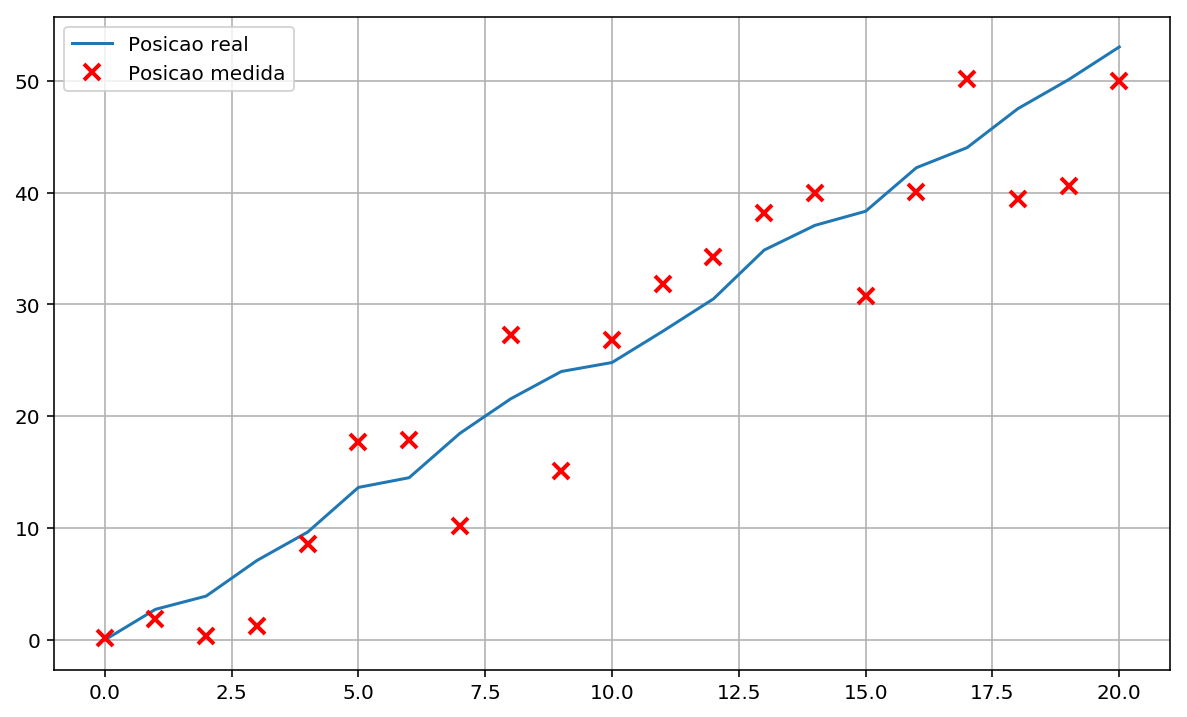

In [8]:
# Inicializacao
posicao = 0
velocidade = 5
tf = 10
dt = .5
Q = 1 # Variancia do modelo
R = 5 # Variancia do sensor

pos_real = [posicao]
zs = [posicao + np.random.normal(0, R)]

for t in np.arange(0, tf, dt):
    # Incrementa posicao
    ruido_sistema = np.random.normal(0, Q)
    posicao = posicao + movimento(t, dt, posicao, velocidade) + ruido_sistema
    pos_real.append(posicao)
    
    # Acrescenta ruido do sensor
    zs.append(posicao + np.random.normal(0, R))

plt.figure(figsize=(10,6))
plt.plot(pos_real)
plt.plot(zs, 'xr', mew = 2, ms = 8)
plt.grid()
plt.legend(["Posicao real", "Posicao medida"]);

### Executando filtro de kalman

In [9]:
# Inicializacao
# Para ilustrar o funcionamento do filtro,
# a posição inicial (posterior[0]) recebe zs[0] + 50
posterior = gaussian(zs[0]+50, R)
predito = []
estimado = []
modelo = []
for z in zs:
    dx = movimento(t, dt, posterior.mean, velocidade)
    
    prior = predict(posterior, gaussian(dx, Q))
    posterior = update(prior, gaussian(z, R))
    
    modelo.append(gaussian(dx, Q))
    predito.append(prior)
    estimado.append(posterior)

In [10]:
interact(
    plot_kalman_steps, 
    step = IntSlider(1, 1, (int(tf/dt)-1)*4),
    pos_real = fixed(pos_real),
    modelo = fixed(modelo),
    predito = fixed(predito),
    estimado = fixed(estimado),
    zs = fixed(zs),
    R = fixed(R)
);

interactive(children=(IntSlider(value=1, description='step', max=76, min=1), Output()), _dom_classes=('widget-…

## Gaussianas Multivariadas

**Objetivo: Função Gaussiana Multivariada**

Para modelar problemas com diversas variáveis, queremos obter as propriedades matemáticas das gaussianas para sitemas com mais que uma variável. Em problemas do mundo real, eventos probabilísticos interagem entre si e alteram o resultado um do outro. Então é natural considerar Funções Gaussianas de múltiplas variáveis.

Enquanto em uma dimensão tínhamos uma variável prevista pelo modelo e uma variável medida, agora temos diversas variáveis de modelo e diversas variáveis medidas, e elas podem ou não interferir no resultado uma da outra. Além disso, sua incerteza pode ou não interferir no resultado uma da outra.

Então agora vamos lidar com um conjunto de dados multidimensional. Cada variável de modelo é associada a sua própria média, assim como cada variável medida.:

$
\vec{x} = \begin{bmatrix}x_1\\x_2\\ \vdots \\x_n\end{bmatrix}  $ $\vec{z} = \begin{bmatrix}z_1\\z_2\\ \vdots \\z_n\end{bmatrix}$

Note que agora o resultado do modelo $\vec{x}$ e as medições $\vec{z}$ são caracterizados como vetores.

**Covariância**

Agora que consideramos diversas variáveis que podem depender uma das outras, é esperado que a imprecisão de um resultado também afete o outro. Por isso agora iremos considerar uma matriz de covariância, onde guardamos informação da relação de variância entre todas as incógnitas.

$$
P = \begin{bmatrix}
  P_1^2 &amp; P_{12} &amp; \cdots &amp; P_{1n} \\
  P_{21} &amp;P_2^2 &amp; \cdots &amp; P_{2n} \\
  \vdots  &amp; \vdots  &amp; \ddots &amp; \vdots  \\
  P_{n1} &amp; P_{n2} &amp; \cdots &amp; P_n^2
 \end{bmatrix}
$$
$$
R = \begin{bmatrix}
  R_1^2 &amp; R_{12} &amp; \cdots &amp; R_{1n} \\
  R_{21} &amp;R_2^2 &amp; \cdots &amp; R_{2n} \\
  \vdots  &amp; \vdots  &amp; \ddots &amp; \vdots  \\
  R_{n1} &amp; R_{n2} &amp; \cdots &amp; R_n^2
 \end{bmatrix}
$$

Note que as incertezas $P$ e $R$ associadas ao modelo e às medições são representadas matematicamente por matrizes. Cada elemento dessas matrizes simétricas é uma covariância entre duas variáveis.


In [11]:
interact(
    interactive_covariance,
    v_a = FloatSlider(value = 2, min = .1, max = 10),
    v_b = FloatSlider(value = 2, min = .1, max = 10),
    v_ab = FloatSlider(value = 0, min = 0, max = 5)
);

interactive(children=(FloatSlider(value=2.0, description='v_a', max=10.0, min=0.1), FloatSlider(value=2.0, des…

In [12]:
interact(
    interactive_covariance_multiply,
    x1 = FloatSlider(value = 2, min = .1, max = 10),
    x2 = FloatSlider(value = 2, min = .1, max = 10),
    x12 = FloatSlider(value = 0, min = 0, max = 5),
    z1 = FloatSlider(value = 2, min = .1, max = 10),
    z2 = FloatSlider(value = 2, min = .1, max = 10),
    z12 = FloatSlider(value = 0, min = 0, max = 5)    
);

NameError: name 'interactive_covariance_multiply' is not defined

<img src="./fig/gaussiancomp.png" style="width: 15cm">




## Kalman Filter Multivariado

Muitas vezes estamos interessados em sistemas que não são descritos por uma, mas sim por várias variáveis de estado e que existem diversos sensores tomando medidas. Nesses casos, é necessário trabalhar com a versão multivariada do Kalman Filter, que se baseia na teoria de **Gaussianas Multivariadas.**

Isso implica que a *média* e *variância* utilizados no Kalman Filter Unidimensional serão substituídos por um *vetor de médias* e uma *matriz de covariância*. Por consequência, as operações ralizadas no Kalman Fiter Unidimensional terão que ser adaptadas para operações com matrizes e vetores, usando **álgebra linear**.


### Kalman Filter Univariado VS Multivariado

<img src="./fig/esquema_kf.png" style="width: 15cm">

Como podemos ver no esquema, os dois algoritmos são analagos. No entanto, no caso multivariado há o acrescimo de algumas variáveis.

### Variáveis

Na figura abaixo, são apresentadas as variáveis envolvidas no Kalman Filter Unidimensional e Multivariado. As variáveis de estado, medidas e modelo estão presentes em ambos. Para estas variáveis, as respectivas versões são apresentadas lado a lado. Já a função de medidas e as variáveis de controle são excluisvas do Filtro Multivariado. 

<img src="./fig/variaveis.png" style="width: 15cm">


- $(x,P)$ é o par que representa as variáveis de estado e a matriz de covariância associada.
- $(F,Q)$ é o par que representa o modelo e a matriz de covariância associada. 

A matriz $F$ é chamada de **matriz de transição** (transition matrix). A ideia é que essa matriz receba um estado e compute uma previsão para o estado seguinte (forma matricial de equações de diferenças!). 

- $(z,R)$ é o par que representa as medidas realizadas e a matriz de covariância associada.
- $H$ é a **função de medições** (measurement function).

Em muitos casos, as variáveis que estamos interessados em estimar não correspondem à variáveis cujos sensores realizam medições. Um exemplo em que isso acontece é quando estamos interessados em modelar a temperatura em certo ambiente, mas possuímos um termometro que retorna medições de voltagem. Nesse caso, antes de incorporar as medições ao modelo, elas devem ser adaptadas para terem a mesma unidade. No caso multidimensional, essa "correção" é realizada pela função de medições.

- $u$ é a variável de controle e $B$ é a função de controle (*opcionais*).



## Etapas

Da mesma forma que o Kalman Filter Unidimensional, o caso multivariado se divide em três etapas: *inicialização, predict e update*. Vamos entender como cada um deles funciona.

### *Inicialização*

**Ideia:** Fornecer valor de estado inicial e matriz de covariância inicial.


### *Predict Step*

**Ideia:** usar o modelo fazer uma previsão sobre o estado do sistema no próximo intervalo de tempo e estimar o erro associado com essa previsão.

1. Usar o modelo para computar o prior $$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}.$$

2. Computar a matriz de covariância do prior $$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q. $$

Esta equação computa a matriz de covariância do prior com base na matriz de covariância do tempo anterior. Intuitivamente, erro do prior seria o erro que já tinhamos somado do erro que o modelo acrescenta, ou seja, $\overline{P} = P + Q$. Na prática, é exatamente isso que esta equação faz. A matriz $F$ aparece no termo $\mathbf{FPF}^\mathsf T$ para projetar a matriz $P$ no espaço da função $F$. Depois que isso é feito, os erros podem ser somados normalmente. 

### *Update Step*

**Ideia:** incorporar informações de medidas ao prior, de modo a obter estimativa final para o estado do sistema no próximo intervalo de tempo.

1. Obter uma medida $z$ e matriz de covariância $R$ associada a elas.
2. Computar o residuo entre o pior e a medida $$\mathbf y = \mathbf z - \mathbf{H\bar{x}}.$$

Esta equação implica que estamos tomando o prior, convertendo o para o espaço de medições e utilizando o resultado para computar o resíduo. Isso significa que o resíduo possui unidade igual à da medição.

3. Computar fator de escala baseado no que acreditamos ser mais acurado, nosso modelo ou medida $$\mathbf K = \frac{\mathbf{\bar{P}H}^\mathsf T }{(\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)} .$$

Lembramos da versão Univariada que o Kalman Gain é um fator que determina quão próximo do prior e da medição que o posterior estará. Ele era computado como a proporção da variância do prior em relação à variância total. É  exatamente isso que fazemos no caso multivariado, porém precisamos "corrigir" as unidades. O termo $\mathbf{\bar{P}H}^\mathsf T$ toma a matriz de covariância do prior e a converte para unidades de medição, enquanto o termo $(\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)$ projeta a covariância do prior no espaço das medições e o soma com a covariância das medições.

4. Usar o fator de escala para obter a estimativa final(posterior). O valor estará entre o prior e a medida.
$$x  = \bar{\mathbf x} + \mathbf{Ky}$$

Note que $y$ tem unidade igual à medição. Com isso, podemos concluir que o "incremento" esta sendo decidido apenas com base na variável que foi medida. Isso faz sentido, já que sabemos que o Kalman Gain é uma constante que relaciona medições com previsões. Ainda assim, esse "incremento" é utilizado para todas as variáveis, mesmo aquelas que não possuem medições associadas.

5. Combinar a matriz de covariância do prior e das medidas para calcular a matriz de covariância associada ao posterior.
$$\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}.$$

## Implementação Kalman Filter Multivariado

## Exemplo: Fazenda de Coelhos 🐰

Vamos supor que temos duas fazendas com criação de coelhos.

<img src="./fig/esquema.png" style="width = 5cm">

Vamos supor o seguinte modelo de equações de diferenças:

$$x_{k+1} = 1.3x + 0.1y\\
y_{k+1} = 0.2x + 1.4y $$

que, em forma matricial, pode ser escrito como

$$\left\lbrack\begin{array}{c}
        x_{k+1}\\
        y_{k+1}
        \end{array}\right\rbrack
        = \left\lbrack\begin{array}{cccc}
        1.3 & 0.1 \\
        0.2 & 1.4 
        \end{array}\right\rbrack
        \left\lbrack\begin{array}{c}
        x_k\\
        y_k
        \end{array}\right\rbrack.
$$

Este será o nosso modelo, ou seja,  $$ F = \left\lbrack\begin{array}{cccc}
        1.3 & 0.1 \\
        0.2 & 1.4 
        \end{array}\right\rbrack. $$

A construção da matriz $H$ depende de quais variáveis possuímos medições. Vamos inicialmente avaliar o caso mais simples, em que existe um sensor em cada fazenda que mede diretamente o número de coelhos. Em seguida, veremos quais adaptações seriam necessárias quando outras medições são feitas.

### CASO 1

**Modelar:** número de coelhos em cada fazenda.
**Medições:** número de coelhos em cada fazenda.

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}\mathrm{Resíduo} \end{bmatrix} &= \begin{bmatrix}\mathrm{Coelhos~Jones}\\\mathrm{Coelhos~Mc~Gregor}\end{bmatrix} - \begin{bmatrix}?&?\\?&?\end{bmatrix} \begin{bmatrix} \mathrm{Coelhos~Jones}\\ \mathrm{Coelhos~Mc~Gregor}\end{bmatrix}
\end{aligned}
$$

Para ter equivalência de unidades, tomamos $H = \begin{bmatrix}1&0\\0&1\end{bmatrix}$.

## Geração das Variáveis do Modelo

In [13]:
#Função de Transição
F = np.array([[1.3, 0.1], [0.2, 1.4]]) 

#Matriz de Covariância do Processo 
Q = cov_matrix(4, 4, -.95)

#Matriz de Covariância dos Sensores. Supomos que covariância é zero. Ou seja, um sensor não influencia no outro.
R = np.array([[150,0], [0,150]]) 

#Measurement Function
H = np.array([[1,0], [0,1]])

NameError: name 'cov_matrix' is not defined

## Geração das Observações e da Curva do Modelo

In [14]:
#Número inicial de coelhos em cada fazenda.
x = np.array([1, 3])

teo = []
zs = []
t0 = 0; tf = 11
t = np.linspace(t0, tf, tf)

#Gera curva do modelo com erro (curva teórica)
for i in t:
    q = np.random.multivariate_normal(mean = [0,0], cov = Q)
    x = F @ x + q
    teo.append(x.copy())
    
    z = np.random.multivariate_normal(mean = [0,0], cov = R)
    zs.append(x + z)

teo = np.asarray(teo)
zs = np.asarray(zs)

ValueError: cov must be 2 dimensional and square

## Implementação do Kalman Filter Multivariado

In [15]:
# x inicial para o filtro de Kalman.
x = np.array([zs[0,0], zs[0,1]]) 

# Matriz de Covariância incial associada à estimativa de número de coelhos em cada fazenda.
P = np.diag([1, 1])

n = len(zs) #número de observações
pred, xs, cov = [], [], []
for z in zs:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    pred.append(x.copy())
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x.copy())
    cov.append(P.copy())

pred, xs, cov = np.array(pred), np.array(xs), np.array(cov)

TypeError: list indices must be integers or slices, not tuple

NameError: name 'plot_coelhinhos' is not defined

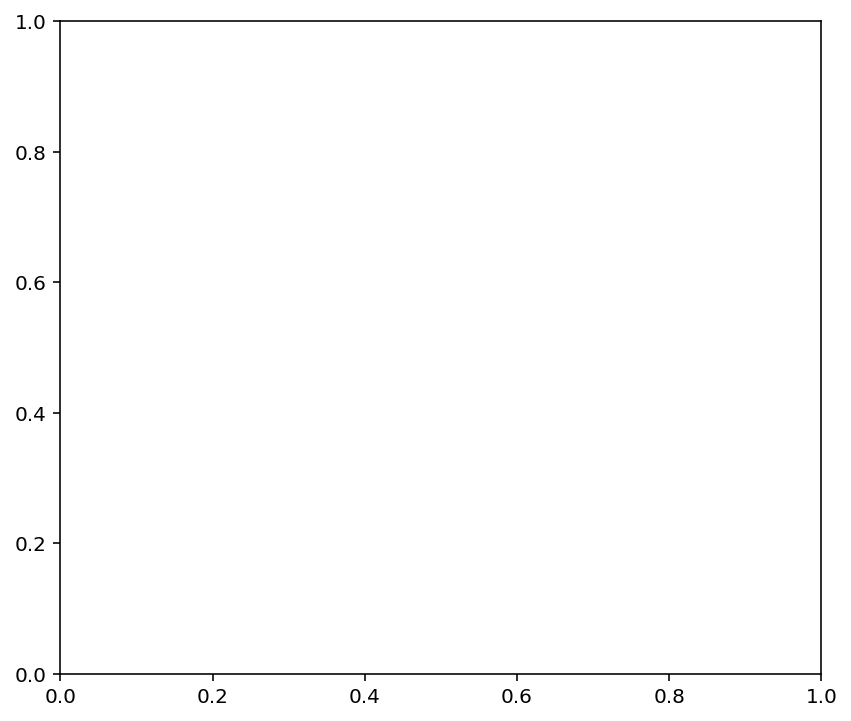

In [16]:
fig = plt.figure(figsize = (15, 6))
ax = plt.subplot(121)
plot_coelhinhos(teo[:,0], zs[:,0], pred[:,0], xs[:,0], "James", ax)
ax = plt.subplot(122)
plot_coelhinhos(teo[:,1], zs[:,1], pred[:,1], xs[:,1], "Mc Gregor", ax)

## Algumas Outras Adaptações Possíveis

### CASO 2

**Modelar (x):** número de coelhos em cada fazenda.
**Medições (z):** número de coelhos na Fazenda do Jones.

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}\mathrm{Resíduo} \end{bmatrix} &= \begin{bmatrix}\mathrm{Coelhos~Jones}\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix} \mathrm{Coelhos~Jones}\\ \mathrm{Coelhos~Mc~Gregor}\end{bmatrix}
\end{aligned}
$$

Note que $z$ é dado em Coelhos de Jones. Assim, o produto $H\overline{x}$ deve também ter essa unidade. Assim, tomamos $H = \begin{bmatrix}1&0\end{bmatrix}$.


### CASO 3

**Modelar (x):** número de coelhos em cada fazenda.
**Medições (z):** kg de ração consumido em cada fazenda.

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}\mathrm{Resíduo} \end{bmatrix} &= \begin{bmatrix}\mathrm{Kg~Ração~Jones}\\\mathrm{Kg~Ração~Mc~Gregor}\end{bmatrix} - \begin{bmatrix}?&?\\?&?\end{bmatrix} \begin{bmatrix} \mathrm{Coelhos~Jones}\\ \mathrm{Coelhos~Mc~Gregor}\end{bmatrix}
\end{aligned}
$$

Vamos considerar que cada coelho come, teoricamente, $0.2kg$ de ração por dia na fazenda do Jones e $0.3kg$ de ração por dia na fazenda do Mc Gregor. Então, tomamos $H = \begin{bmatrix}0.2&0\\0&0.3\end{bmatrix}$.

### CASO 4

**Modelar (x):** número de coelhos em cada fazenda.
**Medições (z):** kg de ração consumido na fazenda do Jones.

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}\mathrm{Resíduo} \end{bmatrix} &= \begin{bmatrix}\mathrm{Kg~Ração~Jones}\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix} \mathrm{Coelhos~Jones}\\ \mathrm{Coelhos~Mc~Gregor}\end{bmatrix}
\end{aligned}
$$

Note que $z$ é dado em Coelhos de Jones. Assim, o produto $H\overline{x}$ deve também ter essa unidade. Assim, tomamos $H = \begin{bmatrix}0.2&0\end{bmatrix}$.


## Contexto das Vaquinhas 🐄

### Referências
Labbe, Roger (2018). Kalman and Bayesian Filters in Python. https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python, commit e84f8018366438c87189ccad40a56bf506f81ffc.